### loading the questions

In [ ]:
import os
import json
import pandas as pd

questions_paths = [f for f in os.listdir(os.getcwd()) if f.endswith('.json')]
df = ''
try:
    for path in questions_paths:
        with open(path, mode = 'r') as file:
            data = json.load(file)
            if isinstance(df, pd.DataFrame):
                df = pd.concat([df, pd.DataFrame(data)], axis = 0)
            else:
                df = pd.DataFrame(data)
except Exception as e:
    print(e)

In [17]:
print(f"the total number of questions is: {len(df)}")

the total number of questions is: 282


exporting the questions

In [18]:
df.to_csv('questionaire.csv', index = False)

### data modifications to the questions

In [20]:
import pandas as pd
questionaire = pd.read_csv('questionaire.csv')
questionaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   questions  282 non-null    object
 1   answers    282 non-null    object
dtypes: object(2)
memory usage: 4.5+ KB


replace the citations

In [21]:
import re
pattern = re.compile(r"\[cite:\s*\d+(?:\s*,\s*\d+)*\]")
questionaire['answers'] = questionaire['answers'].str.replace(pattern, '', regex = True)
questionaire.to_csv('questionaire (no citations).csv', index = False)


### answers from a model with no context

In [ ]:
import pandas as pd
from groq import Client
import os

class NoContextModel:
    def __init__(self, api_key):
        self.api_key = api_key
    
        self.client = Client(
            api_key = self.api_key
        )
        
        self.conversation = [
            {
                "role" : "system",
                "content" : "you are a helpful AI assistant expert on Green House Gas Protocols and Environmental regulation"
            },
            {
                "role" : "assistant",
                "content" : "provide a concise answer to the user's question"
            }
        ]
    def generate_answer(self, user_input : str):
        self.conversation.append(
            {
                "role" : "user",
                "content" : user_input
            }
        )
        try:
            chat_completion = self.client.chat.completions.create(
                model = 'gemma2-9b-it',
                messages = self.conversation,
                max_completion_tokens = 200,
                temperature = 0.5
            )
            return chat_completion.choices[0].message.content
        except Exception as e:
            print(e)
            return ''
        
test_model = NoContextModel(
    api_key = os.getenv("GROQ_API_KEY")
)

questionaire = pd.read_csv('questionaire (no citations).csv')

questionaire['answers (no context)'] = questionaire['questions'].apply(lambda text: test_model.generate_answer(text))
 

Error code: 429 - {'error': {'message': 'Rate limit reached for model `gemma2-9b-it` in organization `org_01jn7qyhdxfbk9rkkm0eqm86pf` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 495775, Requested 4870. Please try again in 1m51.29s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Error code: 429 - {'error': {'message': 'Rate limit reached for model `gemma2-9b-it` in organization `org_01jn7qyhdxfbk9rkkm0eqm86pf` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used 495774, Requested 4892. Please try again in 1m54.9836s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Error code: 429 - {'error': {'message': 'Rate limit reached for model `gemma2-9b-it` in organization `org_01jn7qyhdxfbk9rkkm0eqm86pf` service tier `on_demand` on tokens per day (TPD): Limit 500000, Used

In [33]:
questionaire.to_csv('partial responses questionaire.csv', index = False)

In [1]:
import pandas as pd
questionaire = pd.read_csv('partial responses questionaire.csv')

In [5]:
from groq import Client
import os
class NoContextModel:
    def __init__(self, api_key):
        self.api_key = api_key
    
        self.client = Client(
            api_key = self.api_key
        )
        
        self.conversation = [
            {
                "role" : "system",
                "content" : "you are a helpful AI assistant expert on Green House Gas Protocols and Environmental regulation"
            },
            {
                "role" : "assistant",
                "content" : "provide a concise answer to the user's question"
            }
        ]
    def generate_answer(self, user_input : str):
        self.conversation.append(
            {
                "role" : "user",
                "content" : user_input
            }
        )
        try:
            chat_completion = self.client.chat.completions.create(
                model = 'gemma2-9b-it',
                messages = self.conversation,
                max_completion_tokens = 200,
                temperature = 0.5
            )
            return chat_completion.choices[0].message.content
        except Exception as e:
            print(e)
            return ''
        
test_model = NoContextModel(
    api_key = os.getenv("GROQ_API_KEY")
)


In [30]:
mask = questionaire['answers (no context)'].isnull()
questionaire.loc[mask, 'answers (no context)'] = questionaire.loc[mask, 'questions'].apply(lambda text: test_model.generate_answer(text))

In [32]:
mask = questionaire['answers (no context)'].isnull()
questionaire.to_csv('questionaire (full no context response).csv', index=False)

### generating embeddings from the data

In [3]:
import pandas as pd
questionaire = pd.read_csv('questionaire (full no context response).csv')
questionaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   questions             282 non-null    object
 1   answers               282 non-null    object
 2   answers (no context)  257 non-null    object
dtypes: object(3)
memory usage: 6.7+ KB


In [6]:
mask = questionaire['answers (no context)'].isnull()
questionaire.loc[mask, 'answers (no context)'] = questionaire.loc[mask, 'questions'].apply(lambda text: test_model.generate_answer(text))

In [8]:
questionaire.to_csv('questionaire (part 1).csv', index = False)

In [25]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

sample_text_list = ['what is the weather like today?', 'how much time it takes to travel from sydney to colombia?']

sample_embeddings = model.encode(sample_text_list, convert_to_numpy = True).tolist()

sample_embeddings


[[-0.04205619916319847,
  -0.015622504986822605,
  0.0616811066865921,
  0.03758369758725166,
  0.08791102468967438,
  -0.013381361961364746,
  0.08970431983470917,
  -0.019505072385072708,
  -0.05775909125804901,
  -0.007809935603290796,
  -0.023745287209749222,
  0.045124005526304245,
  0.0022694149520248175,
  -0.02788371592760086,
  0.06320187449455261,
  0.004270315635949373,
  0.06568524986505508,
  -0.0417105033993721,
  0.0031763610895723104,
  -0.017916366457939148,
  -0.13885200023651123,
  -0.003921243827790022,
  -0.11682967841625214,
  0.07509055733680725,
  0.03503072261810303,
  0.12869423627853394,
  -0.050151847302913666,
  0.03641565889120102,
  -0.012164432555437088,
  0.007843365892767906,
  -0.05434085801243782,
  0.023159870877861977,
  0.07504688948392868,
  0.00558208953589201,
  -0.1191222071647644,
  -0.009309371933341026,
  0.057026565074920654,
  -0.07828295230865479,
  -0.06283682584762573,
  -0.0016863923519849777,
  0.042775098234415054,
  -0.075614377856

In [26]:
questionaire['embeddings - answers'] = model.encode(questionaire['answers'].to_list(), convert_to_numpy = True).tolist()
questionaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   questions                          282 non-null    object
 1   answers                            282 non-null    object
 2   answers (no context)               275 non-null    object
 3   embeddings - answers               282 non-null    object
 4   embeddings - answers (no context)  282 non-null    object
dtypes: object(5)
memory usage: 11.1+ KB


In [27]:
questionaire['embeddings - answers (no context)'] = model.encode(questionaire['answers (no context)'].to_list(), convert_to_numpy = True).tolist()
questionaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   questions                          282 non-null    object
 1   answers                            282 non-null    object
 2   answers (no context)               275 non-null    object
 3   embeddings - answers               282 non-null    object
 4   embeddings - answers (no context)  282 non-null    object
dtypes: object(5)
memory usage: 11.1+ KB


In [28]:
questionaire.to_csv('questionaire (answers with embeddings).csv', index = False)


### calculate distances

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

embedding1 = np.array([questionaire['embeddings - answers'][0]])
embedding2 = np.array([questionaire['embeddings - answers (no context)'][0]])
distance = cosine_similarity(embedding1, embedding2)[0][0]
print(f"the distance between embeding 1 and 2 is {distance:.3f}")

the distance between embeding 1 and 2 is 0.664


In [30]:
def calculate_similarity(
    vector1 : list,
    vector2 : list
):
    v1 = np.array(vector1).reshape(1, -1)
    v2 = np.array(vector2).reshape(1, -1)
    return cosine_similarity(v1, v2)[0][0]

questionaire['distance - (truth vs no truth)'] = questionaire.apply(lambda row: calculate_similarity(row['embeddings - answers'], row['embeddings - answers (no context)']), axis = 1)
questionaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   questions                          282 non-null    object 
 1   answers                            282 non-null    object 
 2   answers (no context)               275 non-null    object 
 3   embeddings - answers               282 non-null    object 
 4   embeddings - answers (no context)  282 non-null    object 
 5   distance - (truth vs no truth)     282 non-null    float64
dtypes: float64(1), object(5)
memory usage: 13.3+ KB


In [32]:
questionaire.head()

,questions,answers,answers (no context),embeddings - answers,embeddings - answers (no context),distance - (truth vs no truth)
0,What does the API Compendium detail?,The API Compendium details methodologies for t...,The API Compendium details a set of standardiz...,"[0.005325362551957369, 0.002972154878079891, 0...","[-0.007272238843142986, 0.0042181480675935745,...",0.664349
1,What greenhouse gasses are focused on in the A...,The greenhouse gasses focused on in the API Co...,The API Compendium focuses on greenhouse gases...,"[0.028264878317713737, -0.010375259444117546, ...","[0.0396428145468235, 0.057764310389757156, 0.0...",0.676672
2,What is the main focus of the ESRS E1 standard?,The main focus of the ESRS E1 standard is Clim...,The main focus of the ESRS E1 standard is **cl...,"[0.024370644241571426, 0.01113931555300951, 0....","[0.11005250364542007, -0.018268045037984848, -...",0.850794
3,What is the effective date of the final rule f...,"The final rule is effective January 17, 2025.",The effective date of the final rule for the W...,"[-0.01998976059257984, 0.06043853238224983, 0....","[0.05101114884018898, 0.09315137565135956, 0.0...",0.524422
4,What Act requires the EPA to impose and collec...,The Inflation Reduction Act (IRA) requires the...,The **Inflation Reduction Act of 2022** requir...,"[0.048313163220882416, 0.06350891292095184, 0....","[0.01294984482228756, 0.1074836477637291, 0.09...",0.833216


(array([ 1.,  3., 11., 22., 17., 33., 24., 44., 25., 26.,  9.,  5.,  3.,
         0.,  4.,  2.,  2.,  1.,  0.,  2.,  0.,  0.,  0.,  4.,  1.,  0.,
         1.,  0.,  0.,  1.,  3.,  1.,  1.,  3.,  1.,  1.,  0.,  1.,  4.,
         1.,  2.,  3.,  4.,  4.,  2.,  3.,  3.,  2.,  1.,  1.]),
 array([-0.07213379, -0.05279504, -0.03345629, -0.01411753,  0.00522122,
         0.02455997,  0.04389873,  0.06323748,  0.08257624,  0.10191499,
         0.12125374,  0.1405925 ,  0.15993125,  0.17927001,  0.19860876,
         0.21794751,  0.23728627,  0.25662502,  0.27596378,  0.29530253,
         0.31464128,  0.33398004,  0.35331879,  0.37265754,  0.3919963 ,
         0.41133505,  0.43067381,  0.45001256,  0.46935131,  0.48869007,
         0.50802882,  0.52736758,  0.54670633,  0.56604508,  0.58538384,
         0.60472259,  0.62406134,  0.6434001 ,  0.66273885,  0.68207761,
         0.70141636,  0.72075511,  0.74009387,  0.75943262,  0.77877138,
         0.79811013,  0.81744888,  0.83678764,  0.85612639,

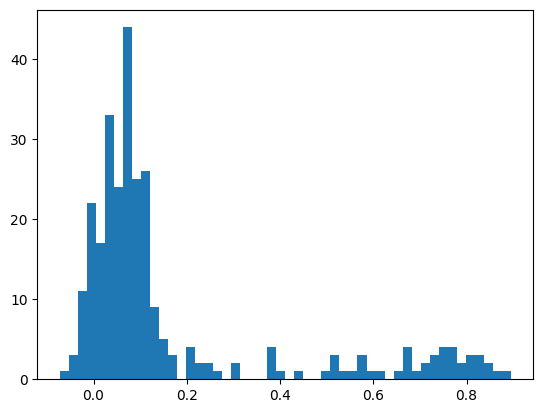

In [33]:
from matplotlib import pyplot as plt

plt.hist(questionaire['distance - (truth vs no truth)'], bins = 50)


In [ ]:
questionaire.to_csv('questionaire (answers with embeddings and distance).csv', index = False)

In [40]:
import sys
from pathlib import Path

# Go up one level from current working directory
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

# Now you can import your module
from src.app.backend import GHGAssistant

ModuleNotFoundError: No module named 'src.app.backend'